# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('final.sqlite') 

#getting the dataset into a dataframe 
final = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time
""", con) 

#prepare training data points
final_train = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time 
limit cast(0.7*(select count(*) from Reviews where ProfileName like "j%") as integer) 
""" , con) 

#prepare testing data points
final_test = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time desc
limit cast(0.3*(select count(*) from Reviews where ProfileName like "j%") as integer) 
""" , con)

In [37]:
final_train['Score'] = final_train['Score'].replace('positive',1)
final_train['Score'] = final_train['Score'].replace('negative',0)
final_test['Score'] = final_test['Score'].replace('positive',1)
final_test['Score'] = final_test['Score'].replace('negative',0)
final_train.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
1,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
2,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...
3,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...
4,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,1,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...


In [4]:
print(final.shape)
print(final_train.shape)
print(final_test.shape)

(37217, 12)
(26051, 12)
(11165, 12)


In [5]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,72060,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,positive,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,delici wafer find european wafer less sweet le...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [8]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'here', 'we', 'been', 'on', 'under', 'whom', 'few', 'herself', 'll', 'couldn', 'other', 'it', 'his', 'about', 'a', 'over', 'y', "haven't", 'again', 'i', "it's", 'same', 'aren', "that'll", 'don', 'at', 'has', 'off', 'only', 'both', 'my', 'against', 'up', 'who', 'into', 'hers', 'mightn', 'when', "hadn't", 'their', 'isn', 'below', 'haven', "shouldn't", "mightn't", 'by', 'each', 'an', 'there', 's', "wouldn't", 'have', 'down', "won't", 'ma', 'themselves', 'he', 'out', 'how', 'didn', 'mustn', 'shouldn', 'further', 'but', 'do', "mustn't", "shan't", 'while', 'in', 'during', 'from', 't', 'where', 'not', 'these', 'yourselves', "she's", "doesn't", 'as', 'your', 'be', 'being', 'too', 'were', 'so', 'then', 'hadn', "don't", 'once', 'him', 'had', 'before', 'or', 'this', "isn't", 'more', "couldn't", 'she', 'them', 'am', 'o', 'you', 'of', 'and', 'that', 'her', 'which', 'ain', 'very', 'why', 've', 'weren', 'himself', 'will', "hasn't", 'to', 'wasn', 'through', 'theirs', 'after', "weren't", 'needn', 'jus

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [10]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# [7.2.6] Word2Vec

In [12]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
import re
i=0
final_train_X=[]
final_train_Y=[]
for sents in final_train.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_train.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_train_X.append(filtered_sentence)
    final_train_Y.append(sents[final_train.columns.get_loc("Score")])
    

i=0
final_test_X=[]
final_test_Y=[]
for sents in final_test.values:
    filtered_sentence=[]
    #print(sents[final_train.columns.get_loc("CleanedText")])
    sent=cleanhtml(sents[final_test.columns.get_loc("CleanedText")])
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    final_test_X.append(filtered_sentence)
    final_test_Y.append(sents[final_test.columns.get_loc("Score")])

In [14]:
w2v_model=gensim.models.Word2Vec(final_train_X,min_count=5, workers=4, size =50)    #size=50,
print(w2v_model)
#print(final_train_X[1])
#w2v_model.wv[final_train_X[1][3]]

Word2Vec(vocab=6911, size=50, alpha=0.025)


In [15]:
# average Word2Vec
# compute average word2vec for each training review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_train_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(sent_vectors_train[1])


min_val=1
for i in range(0,len(sent_vectors_train)):
    for j in range(0,len(sent_vectors_train[0])):
        if sent_vectors_train[i][j] < min_val:
            min_val = sent_vectors_train[i][j]
        else:
            continue

            
# average Word2Vec
# compute average word2vec for each testing review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in final_test_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(sent_vectors_test[1])

#We fould 1 review(19948) has all the vectors as Nan. So we are replacing it with 0
for i in range(len(sent_vectors_train)):
    for j in range(50):
        if sent_vectors_train[i][j] != sent_vectors_train[i][j]:
            sent_vectors_train[i][j]=0


min_val=1
for i in range(0,len(sent_vectors_test)):
    for j in range(0,len(sent_vectors_test[0])):
        if sent_vectors_test[i][j] < min_val:
            min_val = sent_vectors_test[i][j]
        else:
            continue

26051
50
[-0.19303827 -0.02019373  0.27237833 -0.03917598 -0.27568523 -0.08877102
 -0.06999542 -0.14574364  0.13998003  0.25244453  0.50866041 -0.0026984
  0.05328995  0.37173403  0.28497367 -0.1660089  -0.34844782 -0.47153742
  0.12167734  0.00705747  0.38486277 -0.47873748 -0.02214003  0.49932843
 -0.35489414  0.27271344 -0.04667286  0.00680148  0.55767245 -0.10930894
 -0.30723602 -0.37510603  0.07621929 -0.59683872 -0.101252    0.09906412
  0.13362522 -0.02112248  0.33938208  0.35909416 -0.20178777 -0.17866396
 -0.37908041  0.03234564 -0.68136991 -0.44115168  0.19238486  0.51860251
 -0.33061476 -0.14670959]
11165
50
[-0.01905655 -0.0440722   0.15596136  0.10097837 -0.29961806  0.00792276
  0.02172722 -0.16660922  0.2089958   0.51843891  0.50381859 -0.12524522
  0.21782736  0.23210564  0.34212238 -0.21886282 -0.18336725 -0.27324743
  0.0184041   0.16097846  0.39857109 -0.28977922 -0.2450748   0.29247104
 -0.20327417  0.27018265 -0.03361677  0.00554073  0.3984307  -0.03723266
 -0.3930

In [16]:
print(sent_vectors_train[19948])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [17]:
import time
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=10, verbose=False)
model.fit(sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Sai charan\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 1310.0754833221436 seconds



The optimal value of max_depth is 5.


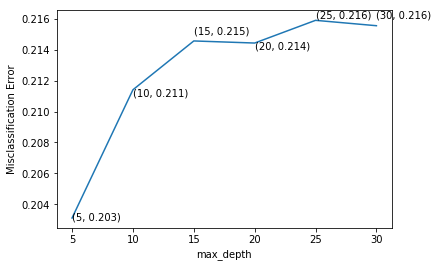

the misclassification error for each max_depth value is :  [0.203 0.211 0.215 0.214 0.216 0.216]


In [18]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    dt = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,max_depth=k, class_weight='balanced')
    dt.fit(sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 252 is:  69.852217%
Confusion matrix for the model is:


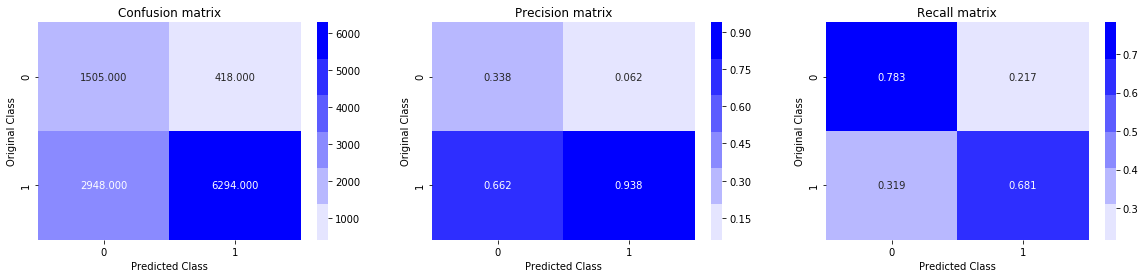

Recall value for the positive class of the model is: 0.6810214239342134
Precision value for the positive class of the model is: 0.9377234803337307
F1 score for the positive class of the model is: 0.7890184279804437


In [19]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [20]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_avgw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(sent_vectors_train)

final_grid_avgw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(sent_vectors_test)

final_grid_avgw2v_test_err=print_auc_score(y_true, y_scores)

print(final_grid_avgw2v_est)
print(final_grid_avgw2v_train_err)
print(final_grid_avgw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
74.82703492599794
73.18263645932117


In [21]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False)
model.fit(sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=25, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 244.59789729118347 seconds



The optimal value of max_depth is 5.


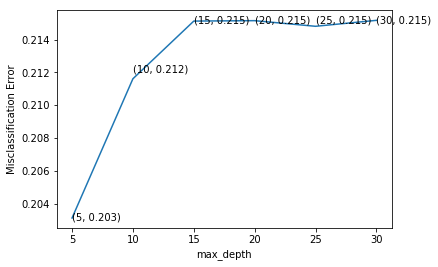

the misclassification error for each max_depth value is :  [0.203 0.212 0.215 0.215 0.215 0.215]


In [22]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 25  and minimum sample split = 252 is:  69.879086%
Confusion matrix for the model is:


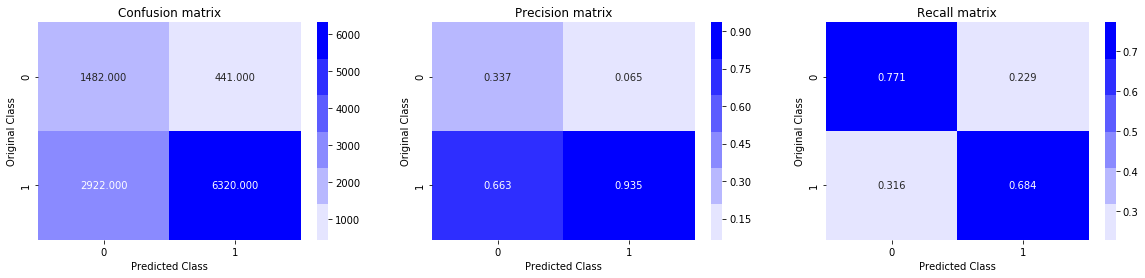

Recall value for the positive class of the model is: 0.683834667820818
Precision value for the positive class of the model is: 0.9347729625795
F1 score for the positive class of the model is: 0.7898519027682309


In [23]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [24]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_avgw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(sent_vectors_train)

final_rand_avgw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(sent_vectors_test)

final_rand_avgw2v_test_err=print_auc_score(y_true, y_scores)

print(final_rand_avgw2v_est)
print(final_rand_avgw2v_train_err)
print(final_rand_avgw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=25, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
79.17291795374769
72.72527473269457


# TF-IDF weighted Word2Vec

In [25]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in final_train_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = to_pass_tfidf_w2v_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

    
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
print(tfidf_sent_vectors_train[1])


# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in final_test_X: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = to_pass_tfidf_w2v_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print(tfidf_sent_vectors_test[1])

26051
50
[-0.29111624 -0.02564301  0.32917169 -0.04230634 -0.27429554 -0.05105616
 -0.07266325 -0.18916994  0.10401918  0.16007444  0.53159591  0.1020388
  0.07524471  0.36992765  0.23324411 -0.1220791  -0.27324101 -0.30875595
  0.20072225 -0.01433124  0.32979441 -0.34408746 -0.02547874  0.30063461
 -0.35831267  0.2472335  -0.12128008 -0.05630295  0.56203372 -0.02104549
 -0.33244657 -0.35609906  0.20435213 -0.49361963 -0.07453695  0.07185214
  0.07300928 -0.01810253  0.28579817  0.24664867 -0.13943864 -0.21552242
 -0.38402782  0.05965454 -0.67768647 -0.38011857  0.13653673  0.42347846
 -0.37271691 -0.10103958]
11165
50
[-0.00964892 -0.09490244  0.15164877  0.07776635 -0.25225074  0.01017703
  0.0049358  -0.16610195  0.13337775  0.3662967   0.41529833 -0.08475889
  0.13822428  0.16278311  0.2177266  -0.22694986 -0.20178465 -0.23267899
  0.0361276   0.1211592   0.32052493 -0.18237633 -0.15278306  0.30671851
 -0.14526119  0.16768261 -0.05362153 -0.02248566  0.34402139 -0.11905684
 -0.3238

In [26]:
#We fould 1 review(19948) has all the vectors as Nan. So we are replacing it with 0
for i in range(len(tfidf_sent_vectors_train)):
    for j in range(50):
        if tfidf_sent_vectors_train[i][j] != tfidf_sent_vectors_train[i][j]:
            tfidf_sent_vectors_train[i][j]=0

In [27]:
#GridSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_grid=tuned_parameters, 
                     scoring = 'roc_auc', cv=10, verbose=False)
model.fit(tfidf_sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=202,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 1325.4889788627625 seconds



The optimal value of max_depth is 5.


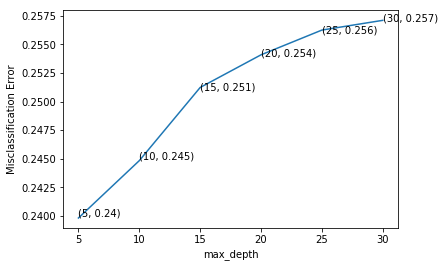

the misclassification error for each max_depth value is :  [0.24  0.245 0.251 0.254 0.256 0.257]


In [28]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []
MSE = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(tfidf_sent_vectors_train, final_train_Y)
    scores = cross_val_score(estimator=nb, X=tfidf_sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 202 is:  70.031348%
Confusion matrix for the model is:


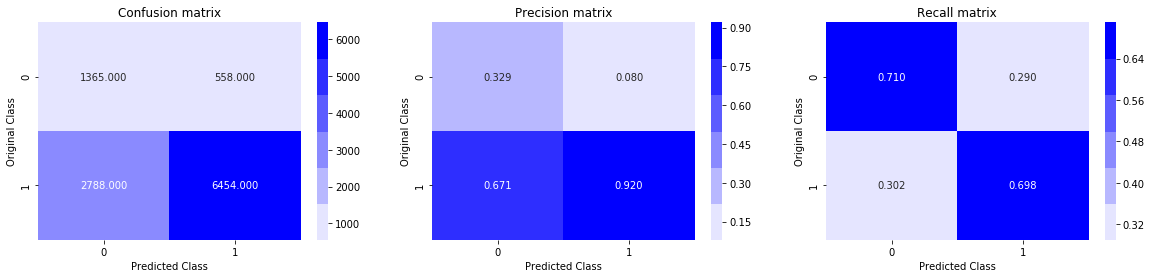

Recall value for the positive class of the model is: 0.6983336940056265
Precision value for the positive class of the model is: 0.9204221334854535
F1 score for the positive class of the model is: 0.7941429801894918


In [29]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(tfidf_sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [30]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_grid_tfidfw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_train)

final_grid_tfidfw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_test)

final_grid_tfidfw2v_test_err=print_auc_score(y_true, y_scores)

print(final_grid_tfidfw2v_est)
print(final_grid_tfidfw2v_train_err)
print(final_grid_tfidfw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=202,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
72.10885069627447
70.4081043570676


In [31]:
#RandomizedSearchCV to find optimal min_samples_split and max_depth
from sklearn.model_selection import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier
start = time.time()

tuned_parameters = {'min_samples_split': [i for i in range(2,302,25)], 
                    'max_depth': [i for i in range(5,31,5)]}

model = RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'), param_distributions=tuned_parameters, 
                           scoring = 'roc_auc', cv=10, verbose=False)
model.fit(tfidf_sent_vectors_train, final_train_Y)
print(model.best_estimator_)
end = time.time()
print("Total running time: %s seconds" % (end - start))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total running time: 130.76636815071106 seconds



The optimal value of max_depth is 5.


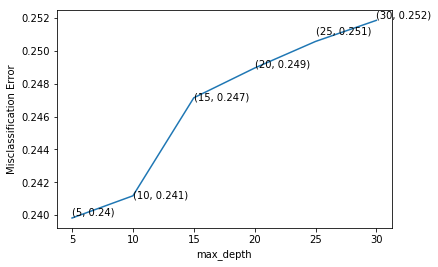

the misclassification error for each max_depth value is :  [0.24  0.241 0.247 0.249 0.251 0.252]


In [32]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in tuned_parameters['max_depth']:
    nb = DecisionTreeClassifier(min_samples_split=model.best_estimator_.min_samples_split,
                                max_depth=k, class_weight='balanced')
    nb.fit(tfidf_sent_vectors_train, final_train_Y)
    #print(nb.predict(X_test[2:39]))
    scores = cross_val_score(estimator=nb, X=tfidf_sent_vectors_train, y=final_train_Y, 
                             cv=10, scoring='roc_auc', verbose=False, n_jobs = 1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = tuned_parameters['max_depth'][MSE.index(min(MSE))]
print('\nThe optimal value of max_depth is %d.' % optimal_alpha)


# plot misclassification error vs k 
plt.plot(tuned_parameters['max_depth'], MSE)

for xy in zip(tuned_parameters['max_depth'], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('max_depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each max_depth value is : ", np.round(MSE,3))

Accuracy of the model at depth of the tree = 5  and minimum sample split = 252 is:  70.031348%
Confusion matrix for the model is:


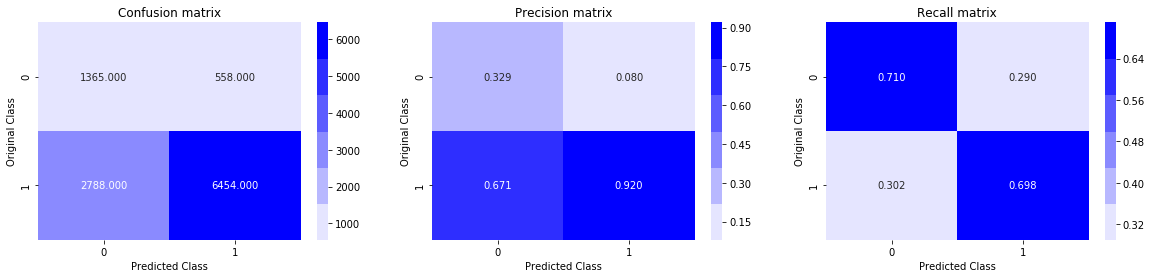

Recall value for the positive class of the model is: 0.6983336940056265
Precision value for the positive class of the model is: 0.9204221334854535
F1 score for the positive class of the model is: 0.7941429801894918


In [33]:
#Finding accuracy, Confusion matrix, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
Y_pred = model.predict(tfidf_sent_vectors_test)
Y_test_accuracy = accuracy_score(final_test_Y, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at depth of the tree = %d  and minimum sample split = %d is:  %f%%' 
      % (model.best_estimator_.max_depth, model.best_estimator_.min_samples_split, Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(final_test_Y, Y_pred)

rec_pre_f1 = precision_recall_fscore_support(final_test_Y, Y_pred)
#print(rec_pre_f1)
print('Recall value for the positive class of the model is: %s'% rec_pre_f1[1][1])
print('Precision value for the positive class of the model is: %s'% rec_pre_f1[0][1])
print('F1 score for the positive class of the model is: %s'% rec_pre_f1[2][1])

#print(rec_pre_f1)

In [34]:
#Saving the results of GridSearchCV BoW representation
from sklearn.metrics import roc_auc_score


final_rand_tfidfw2v_est=model.best_estimator_

def print_auc_score(y_true, y_scores):
    return 100*(roc_auc_score(y_true, y_scores))

y_true=final_train_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_train)

final_rand_tfidfw2v_train_err=print_auc_score(y_true, y_scores)

y_true=final_test_Y
y_scores=model.best_estimator_.predict(tfidf_sent_vectors_test)

final_rand_tfidfw2v_test_err=print_auc_score(y_true, y_scores)

print(final_rand_tfidfw2v_est)
print(final_rand_tfidfw2v_train_err)
print(final_rand_tfidfw2v_test_err)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=252,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
72.10885069627447
70.4081043570676


Error Metric Matrix

In [36]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Baseline Model", " Hyper Parameter", "Train Error", "Test Error"]
x.add_row(["GridSearch Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_avgw2v_est.max_depth, final_grid_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_avgw2v_train_err), "%.2f%%" %(100-final_grid_avgw2v_test_err)])
x.add_row(["Random Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_avgw2v_est.max_depth,  final_rand_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_avgw2v_train_err), "%.2f%%" %(100-final_rand_avgw2v_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_avgw2v_est.max_depth, final_grid_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_avgw2v_train_err), "%.2f%%" %(100-final_grid_avgw2v_test_err)])
x.add_row(["Random Cross Validation on Avg Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_avgw2v_est.max_depth, final_rand_avgw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_avgw2v_train_err), "%.2f%%" %(100-final_rand_avgw2v_test_err)])
#######################################################################################################
x.add_row(["GridSearch Cross Validation on TF-IDF Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_grid_tfidfw2v_est.max_depth,final_grid_tfidfw2v_est.min_samples_split),
           "%.2f%%" % (100-final_grid_tfidfw2v_train_err), "%.2f%%" %(100-final_grid_tfidfw2v_test_err)])
x.add_row(["Random Cross Validation on TF-IDF Word2Vec", 
           "max_depth: %s, min_samples_split: %s" % (final_rand_tfidfw2v_est.max_depth,final_rand_tfidfw2v_est.min_samples_split),
           "%.2f%%" % (100-final_rand_tfidfw2v_train_err), "%.2f%%" %(100-final_rand_tfidfw2v_test_err)])
print(x)

+------------------------------------------------+---------------------------------------+-------------+------------+
|                 Baseline Model                 |             Hyper Parameter           | Train Error | Test Error |
+------------------------------------------------+---------------------------------------+-------------+------------+
|  GridSearch Cross Validation on Avg Word2Vec   |  max_depth: 5, min_samples_split: 252 |    25.17%   |   26.82%   |
|    Random Cross Validation on Avg Word2Vec     | max_depth: 25, min_samples_split: 252 |    20.83%   |   27.27%   |
|  GridSearch Cross Validation on Avg Word2Vec   |  max_depth: 5, min_samples_split: 252 |    25.17%   |   26.82%   |
|    Random Cross Validation on Avg Word2Vec     | max_depth: 25, min_samples_split: 252 |    20.83%   |   27.27%   |
| GridSearch Cross Validation on TF-IDF Word2Vec |  max_depth: 5, min_samples_split: 202 |    27.89%   |   29.59%   |
|   Random Cross Validation on TF-IDF Word2Vec   |  max_